### Построение прогноза среднемесячной зарплаты на основе временных рядов (sarimax)

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
# загружаем исторические данные о среднемесячной зарплате 
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
salary.columns = ['avg_salary']
salary.head()

,avg_salary
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


<Figure size 1080x504 with 0 Axes>

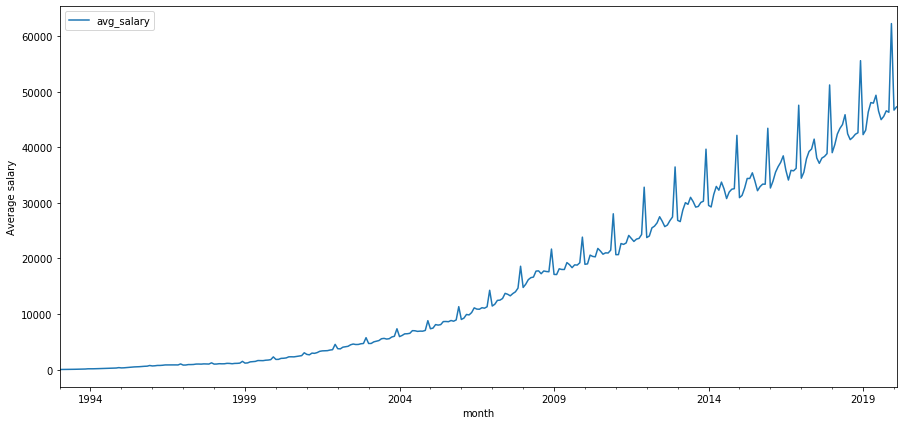

In [3]:
plt.figure(figsize(15, 7))
salary.plot()
plt.ylabel('Average salary')
pylab.show()

В данных выражены тренд и годовая сезонность. Дисперсия значительно увеличиваеся со временем.
Очевидно, что ряд нестационарный

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.998955


<Figure size 1080x720 with 0 Axes>

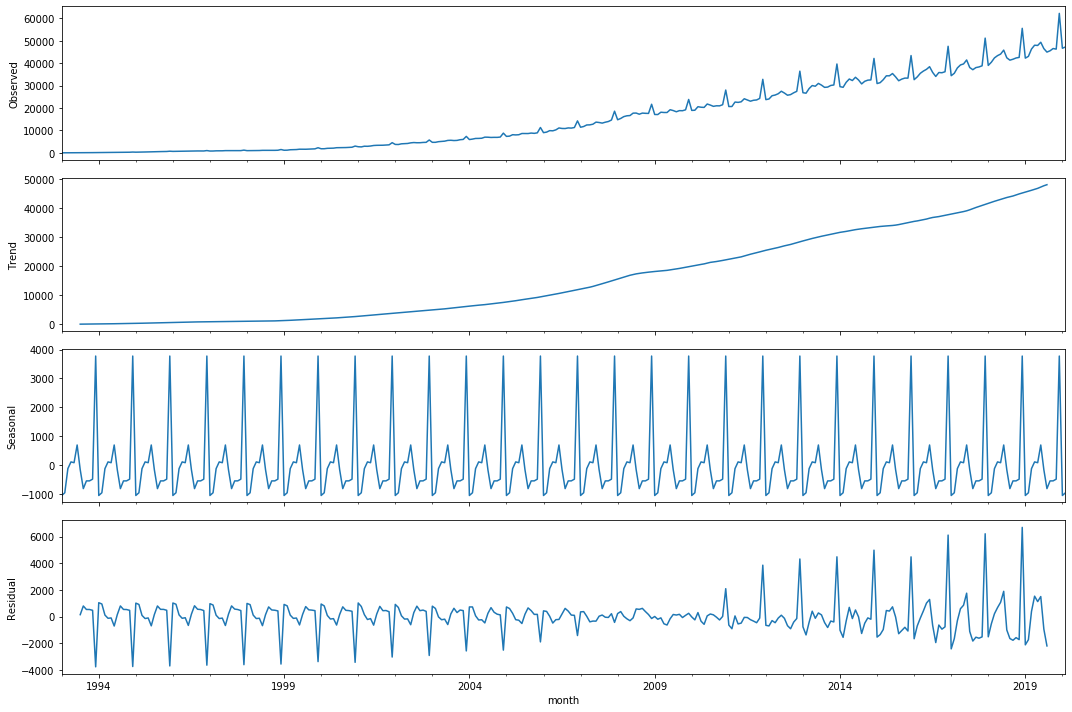

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.avg_salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.avg_salary)[1])

Критерий Дики-Фулера дает значение близкое к единице, и не отвергает гипотезу о нестационарности. Что и ожидалось

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.289506
Критерий Дики-Фуллера: p=0.798398


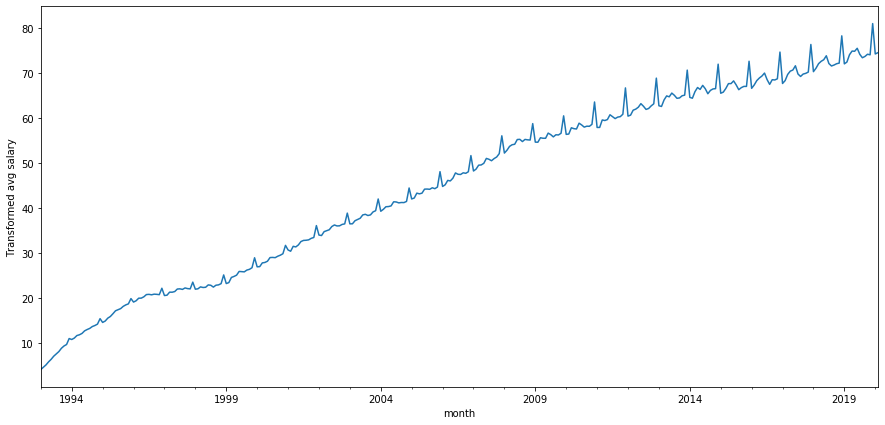

In [5]:
salary['salary_box'], lmbda = stats.boxcox(salary.avg_salary)
plt.figure(figsize(15,7))
salary.salary_box.plot()
plt.ylabel(u'Transformed avg salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

Разброс дисперсии уменьшился, также как и значение критерия Дики-Фулера. Однако существенно картина не изменилась - ряд нестационарный

### Стационарность

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.120531


<Figure size 1080x720 with 0 Axes>

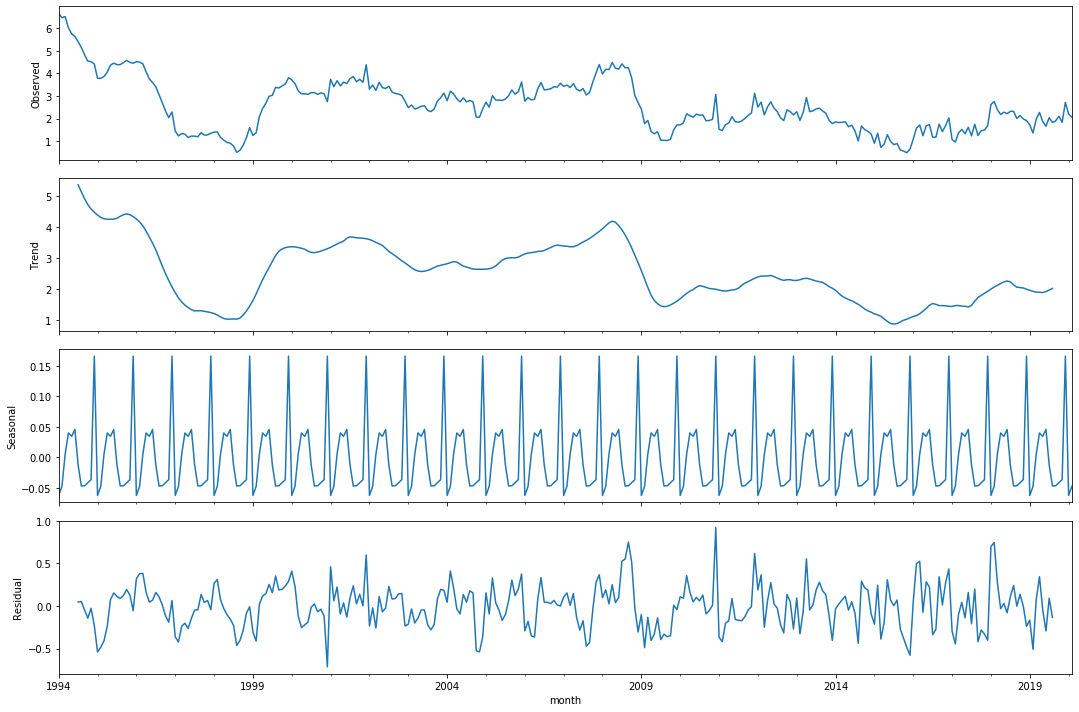

In [6]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось, хотя теперь его направление сменилось на убывающее. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

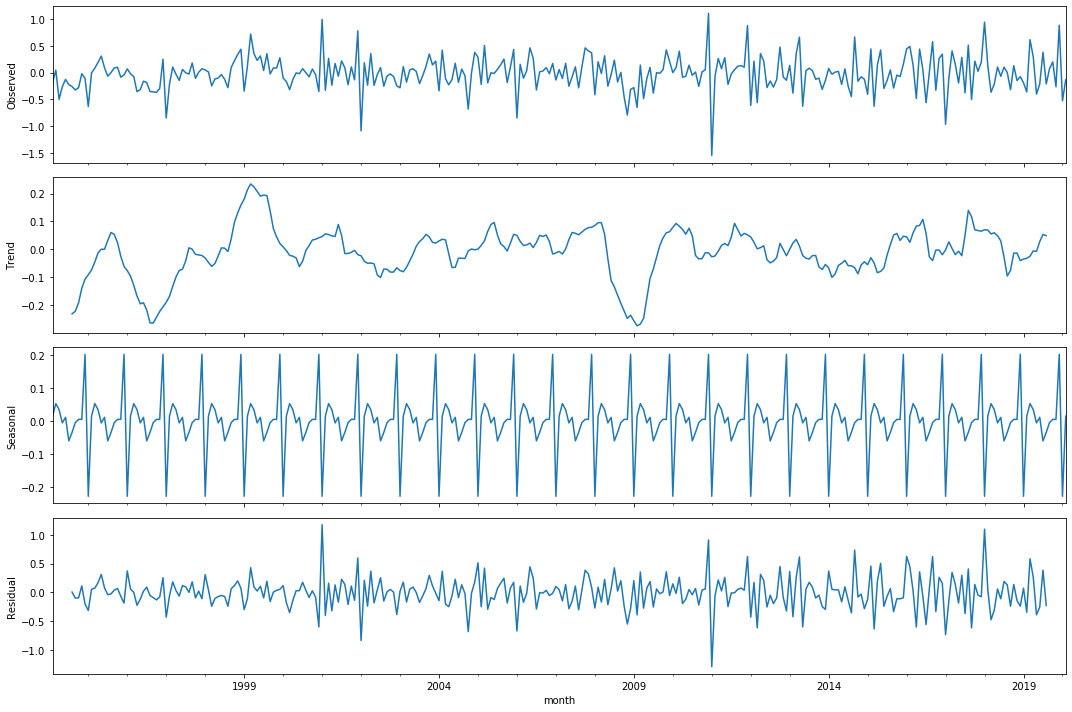

In [7]:
salary['salary_box_diff2'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2[13:])[1])

Критерий Дики-Фулера меньше 0.05. Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

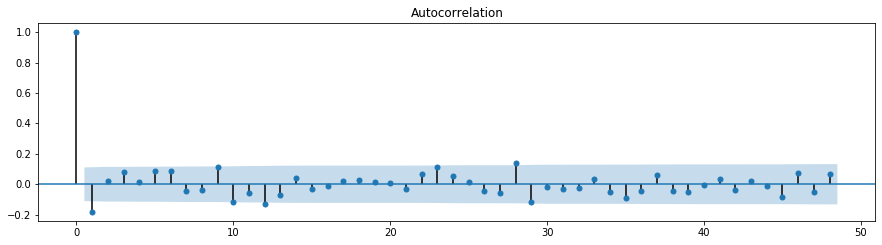

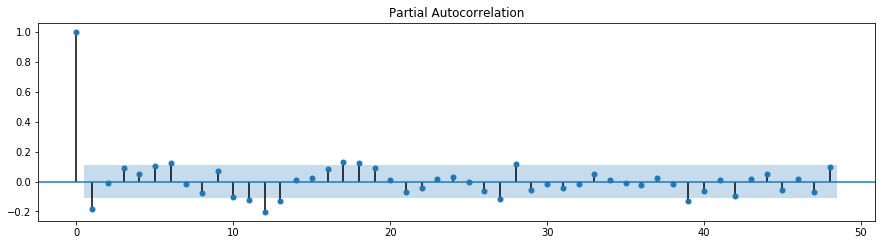

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=1, P=1, p=11

In [9]:
ps = range(0, 12)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

96

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 12min 15s, sys: 7min 54s, total: 20min 10s
Wall time: 5min 21s


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
94  (11, 1, 1, 0)  147.713431
90  (11, 0, 1, 0)  149.086149
95  (11, 1, 1, 1)  149.687538
91  (11, 0, 1, 1)  150.356316
89  (11, 0, 0, 1)  151.847541


Оптимальные значения характеристик: Q=0, q=1, P=1, p=11. В уроке говорили, что лучшей может быть модель из топа, у которой меньше параметров. Но не сказали, как это количественно определять. У 90 модели на 1 параметр меньше, чем у 94, но значение коэфф. акаике больше на 1,3. И поэтому неочевидно, можно ли говорить, что она лучше. Поэтому оставляем 94 модель в качестве лучшей. 

Лучшая модель:

In [13]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                          salary_box   No. Observations:                  326
Model:             SARIMAX(11, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 -59.857
Date:                             Thu, 14 May 2020   AIC                            147.713
Time:                                     14:40:20   BIC                            200.160
Sample:                                 01-01-1993   HQIC                           168.673
                                      - 02-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9009      0.154     -5.860      0.000      -1.202      -0.600
ar.L2         -0.2366      

Её остатки:

Критерий Стьюдента: p=0.312007
Критерий Дики-Фуллера: p=0.000000


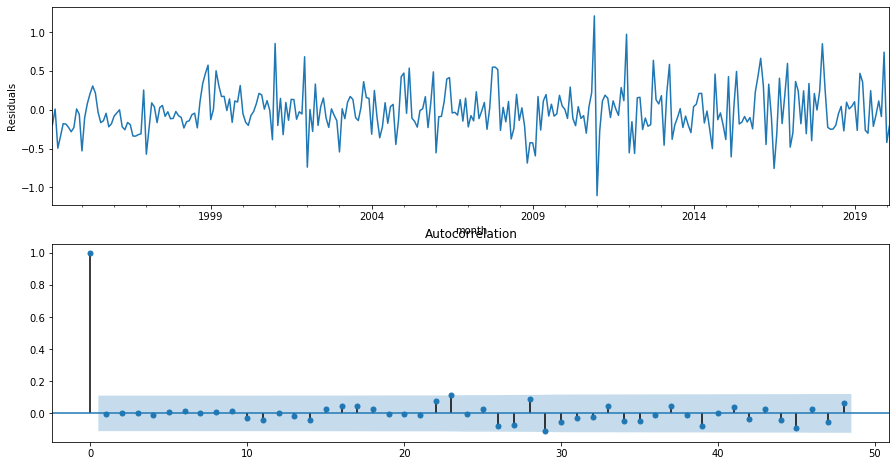

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

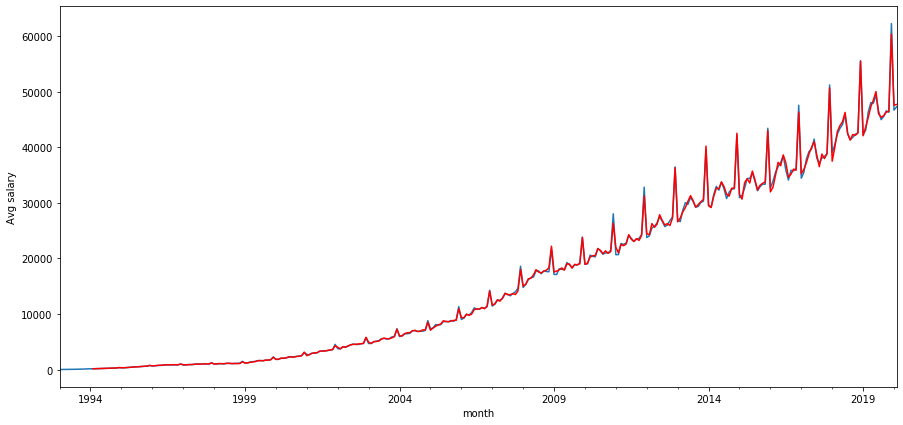

In [15]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.avg_salary.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Avg salary')
pylab.show()

Красный график предсказанных значений достаточно точно повторяет исходный график

### Прогноз

Прогноз на 24 месяца вперед

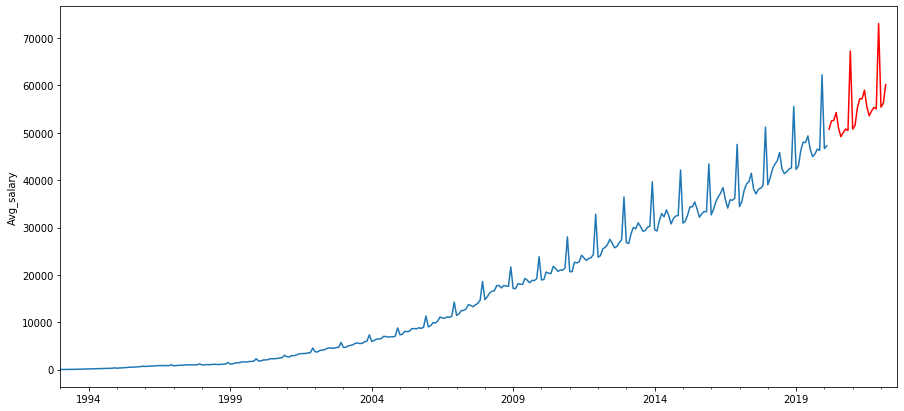

In [17]:
salary2 = salary[['avg_salary']]
date_list = [datetime.datetime.strptime("2020-03-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,30)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=326, end=350), lmbda)

plt.figure(figsize(15,7))
salary2.avg_salary.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Avg_salary')
pylab.show()

Предсказанные значения выглядят логично, по сравнению с наблюдаемыми, тренд продолжается возрастающий, скоро будем зарабатывать по 70 тысяч на новый год. А вот что можно будет купить на эти 70 тысяч - уже отдельный разговор :)